In [97]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DateType
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from pyspark.sql.functions import to_date
import datetime
import pyspark.sql.functions as F

In [2]:
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("david_task")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/18 10:22:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/18 10:22:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/18 10:22:40 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [76]:
uber_data_janJune = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-janjune-15.csv')
zones = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/taxi-zone-lookup.csv')
uber_data_may = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-may14.csv')

In [98]:
df1 = uber_data_may.rdd.map(lambda x: (datetime.datetime.strptime(x[0].split(" ")[0], '%d/%m/%Y').strftime('%Y-%m-%d'), x[0].split(" ")[1], x[1], x[2], x[3])).toDF()
data = df1.select(col("_1").alias("date"), col("_2").alias("hour"), col("_3").alias("lat"), col("_4").alias("long"), col("_5").alias("long"))
data = data.withColumn("date",data["date"].cast(DateType()))

In [99]:
 data2=data.withColumn('weekday',F.date_format(data["date"],'E'))

In [100]:
data2.show()

+----------+-------+-------+--------+------+-------+
|      date|   hour|    lat|    long|  long|weekday|
+----------+-------+-------+--------+------+-------+
|2014-01-05|0:02:00|40.7521|-73.9914|B02512|    Sun|
|2014-01-05|0:06:00|40.6965|-73.9715|B02512|    Sun|
|2014-01-05|0:15:00|40.7464|-73.9838|B02512|    Sun|
|2014-01-05|0:17:00|40.7463|-74.0011|B02512|    Sun|
|2014-01-05|0:17:00|40.7594|-73.9734|B02512|    Sun|
|2014-01-05|0:20:00|40.7685|-73.8625|B02512|    Sun|
|2014-01-05|0:21:00|40.7637|-73.9962|B02512|    Sun|
|2014-01-05|0:21:00|40.7252|-74.0023|B02512|    Sun|
|2014-01-05|0:25:00|40.7607|-73.9625|B02512|    Sun|
|2014-01-05|0:25:00|40.7212|-73.9879|B02512|    Sun|
|2014-01-05|0:29:00|40.7255|-73.9986|B02512|    Sun|
|2014-01-05|0:32:00|40.6467|-73.7901|B02512|    Sun|
|2014-01-05|0:40:00|40.7613|-73.9788|B02512|    Sun|
|2014-01-05|0:56:00|40.7807|-73.9497|B02512|    Sun|
|2014-01-05|1:00:00|40.7585|-73.9708|B02512|    Sun|
|2014-01-05|1:02:00|40.7163|-73.9895|B02512|  

In [5]:
uber_data_may_rdd = uber_data_may.rdd
#filter outliers far away from NYC
x = uber_data_may_rdd.filter(lambda x: (-74.2619 < float(x["Lon"]) < -73.7) 
                                                      and (40.4877 < float(x["Lat"]) < 40.9478))\
                                            .filter(lambda x: x["Date/Time"].split(" ")[0] == "5/1/2014")
uber_data_may = x.toDF()

# Find most popular companies

In [6]:
comp_map = {"B02512": "Unter", "B02598": "Hinter", "B02617": "Weiter", "B02682": "Schmecken", 
            "B02764": "Danach-NY", "B02765": "Grun", "B02835": "Dreist", "B02836": "Drinnen"}

In [7]:
comp_popularity = uber_data_janJune.groupby("Dispatching_base_num").count().sort(col("count").desc())

In [8]:
comp_popularity = comp_popularity.rdd.map(lambda x: (comp_map[x[0]], x[1])).toDF(["company", "occurences"])

In [9]:
comp_popularity.toPandas().to_csv('results/company_popularity_janjune.csv')

# Show location points on the map

In [10]:
nyc_map = gpd.read_file("map/geo_export_c068bb1b-a507-41bc-b2bd-e88bf0d0f649.shp")
# source: https://data.cityofnewyork.us/

In [11]:
# Generate Geo Dataframe
crs =  {"init": "epsg:4326"}
loc = [Point((float(row['Lon']),float(row['Lat']))) for row in uber_data_may.collect()]
base = uber_data_may[["Base"]].toPandas()
geo_df = gpd.GeoDataFrame(base,crs=crs, geometry=loc)

/home/ubuntu/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
colors = ["black", "brown", "yellow", "purple", "red","blue", "green", "orange"]
existing_base_values = geo_df["Base"].unique()

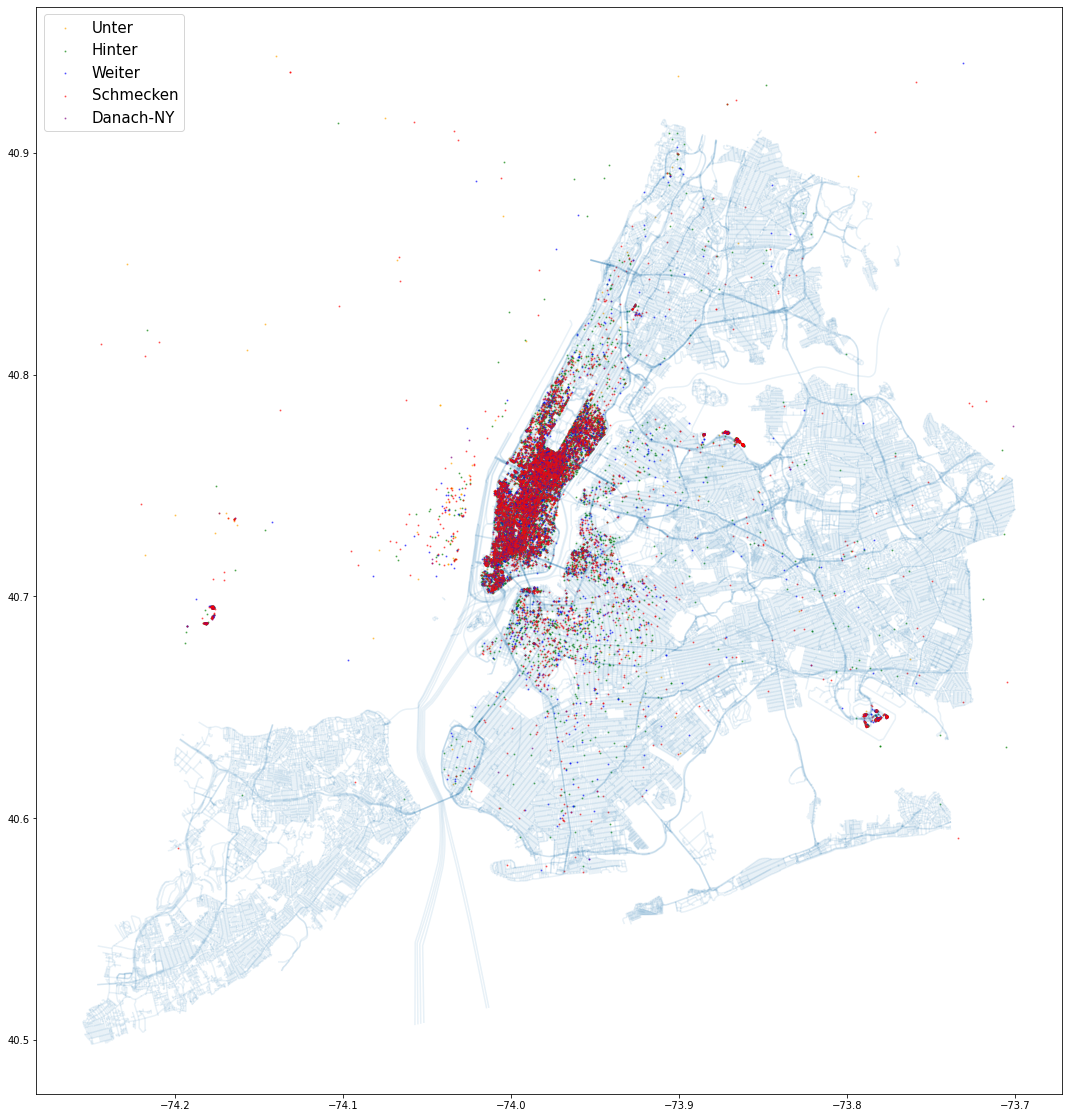

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
nyc_map.plot(ax=ax, alpha=0.1)

for b in existing_base_values:
    geo_df[geo_df["Base"] == b].plot(ax=ax,markersize=1, color=colors.pop(), label=comp_map[b], alpha=0.5)

plt.legend(prop={'size': 15})
#plt.savefig("results/locations.png")

# Company distribution within boroughs

In [14]:
color_map = {"Unter": "red", "Hinter": "green", "Weiter": "orange", "Schmecken": "purple", 
            "Danach-NY": "brown", "Grun": "pink", "Dreist": "black", "Drinnen": "yellow"}

In [15]:
base_boroughs = uber_data_janJune.join(zones, uber_data_janJune.locationID == zones.LocationID)\
                                            .select(uber_data_janJune.Dispatching_base_num, zones.Borough)

In [16]:
base_boroughs = base_boroughs.rdd.map(lambda x: (comp_map[x["Dispatching_base_num"]], x["Borough"]))\
                                                                                .toDF(["base","borough"])

In [17]:
boroughs = zones.select("Borough").distinct().collect()

In [18]:
grouped_boroughs = base_boroughs.groupBy("borough","base").count()

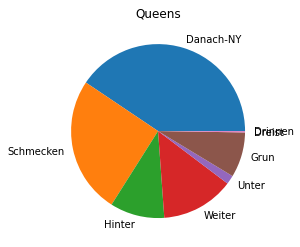

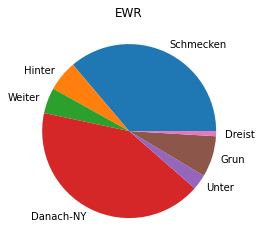

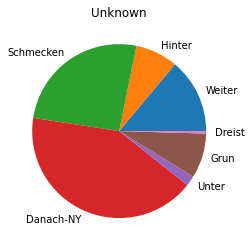

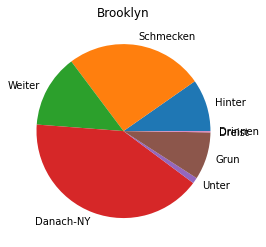

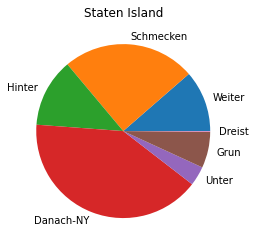

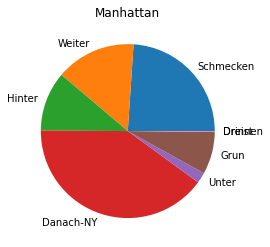

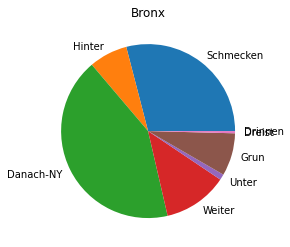

In [22]:
for b in boroughs:
    plt.figure()
    filtered = grouped_boroughs.filter(b["Borough"] == grouped_boroughs.borough).collect()
    occ = []
    comp = []
    borough = b["Borough"]
    for row in filtered:
        occ.append(row["count"])
        comp.append(row["base"])
    plt.pie(occ, labels=comp)
    plt.title(borough)
    plt.savefig(f"results/distribution_{borough}.png")